# TUGAS: KLASIFIKASI NAIVE BAYES - E.coli Dataset

## Melanjutkan dari: "Coli Protein PCA & ADASYN Implementation"

**Tugas Utama:**
1. Implementasi PCA & ADASYN/SMOTE (sudah selesai di notebook sebelumnya)
2. **Klasifikasi dengan Naive Bayes:**
   - Klasifikasi pada **data asli** (sebelum balancing)
   - Klasifikasi pada **data setelah balancing** 
   - **Perbandingan performa** kedua hasil

**Fokus:** Evaluasi dampak data balancing terhadap akurasi klasifikasi  
**Algoritma:** Gaussian Naive Bayes  
**Dataset:** E.coli Protein Localization  

In [60]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Data Balancing 
from imblearn.over_sampling import SMOTE

# Database
import mysql.connector
import urllib.request
import os

print("Libraries berhasil di-import!")

Libraries berhasil di-import!


In [61]:
# LOAD DATA E.COLI
print("=== MEMUAT DATASET E.COLI ===")

try:
    # Coba dari database MySQL
    config = {
        'user': 'root', 'password': '', 'host': 'localhost', 
        'database': 'Ecoli', 'port': 3306
    }
    connection = mysql.connector.connect(**config)
    df = pd.read_sql("SELECT * FROM ecoli", connection)
    connection.close()
    print("Data dari MySQL berhasil dimuat")
    
except:
    # Fallback ke UCI dataset
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ecoli/ecoli.data"
    column_names = ['sequence_name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'class']
    df = pd.read_csv(url, delimiter='\s+', names=column_names)
    print("Data dari UCI berhasil dimuat")

print(f"Dataset shape: {df.shape}")
print(f"Kelas: {df['class'].unique()}")
df.head()

=== MEMUAT DATASET E.COLI ===
Data dari UCI berhasil dimuat
Dataset shape: (336, 9)
Kelas: ['cp' 'im' 'imS' 'imL' 'imU' 'om' 'omL' 'pp']
Data dari UCI berhasil dimuat
Dataset shape: (336, 9)
Kelas: ['cp' 'im' 'imS' 'imL' 'imU' 'om' 'omL' 'pp']


,sequence_name,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [62]:
# PREPROCESSING DATA
print("=== PREPROCESSING DATA ===")

# Pisahkan features dan target
X = df.drop(['sequence_name', 'class'], axis=1)  
y = df['class'] 

print(f"Features: {X.columns.tolist()}")
print(f"Target classes: {y.unique()}")

# Cek distribusi kelas
print(f"\n=== DISTRIBUSI KELAS ===")
class_dist = y.value_counts().sort_index()
print(class_dist)
print(f"Rasio imbalance: {class_dist.max()}/{class_dist.min()} = {class_dist.max()/class_dist.min():.1f}:1")

# Standardisasi features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nData preprocessing selesai!")
print(f"Shape X: {X_scaled.shape}")
print(f"Shape y: {y.shape}")

=== PREPROCESSING DATA ===
Features: ['mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2']
Target classes: ['cp' 'im' 'imS' 'imL' 'imU' 'om' 'omL' 'pp']

=== DISTRIBUSI KELAS ===
cp     143
im      77
imL      2
imS      2
imU     35
om      20
omL      5
pp      52
Name: class, dtype: int64
Rasio imbalance: 143/2 = 71.5:1

Data preprocessing selesai!
Shape X: (336, 7)
Shape y: (336,)


In [63]:
# DATA BALANCING DENGAN SMOTE
print("=== DATA BALANCING DENGAN SMOTE ===")

print("Data asli:")
original_dist = y.value_counts().sort_index()
print(original_dist)

# Gunakan SMOTE untuk balancing (lebih simple dan reliable)
smote = SMOTE(random_state=42, k_neighbors=1)  # k=1 karena beberapa kelas hanya punya 2 sampel
X_smote, y_smote = smote.fit_resample(X_scaled, y)

print(f"\nData setelah SMOTE:")
smote_dist = y_smote.value_counts().sort_index()
print(smote_dist)

print(f"\nRingkasan:")
print(f"• Data asli: {len(y)} sampel")
print(f"• Data setelah SMOTE: {len(y_smote)} sampel") 
print(f"• Data yang di-generate: {len(y_smote) - len(y)} sampel")
print("Selesai!")

=== DATA BALANCING DENGAN SMOTE ===
Data asli:
cp     143
im      77
imL      2
imS      2
imU     35
om      20
omL      5
pp      52
Name: class, dtype: int64

Data setelah SMOTE:
cp     143
im     143
imL    143
imS    143
imU    143
om     143
omL    143
pp     143
Name: class, dtype: int64

Ringkasan:
• Data asli: 336 sampel
• Data setelah SMOTE: 1144 sampel
• Data yang di-generate: 808 sampel
Selesai!


In [64]:
# KLASIFIKASI 1: DATA ASLI (SEBELUM BALANCING)
print("=== KLASIFIKASI 1: DATA ASLI ===")

# Split data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Training Naive Bayes
nb_original = GaussianNB()
nb_original.fit(X_train, y_train)
y_pred_original = nb_original.predict(X_test)

# Evaluasi
acc_original = accuracy_score(y_test, y_pred_original)
print(f"\nAccuracy (Data Asli): {acc_original:.4f}")

print("\nClassification Report (Data Asli):")
print(classification_report(y_test, y_pred_original))

=== KLASIFIKASI 1: DATA ASLI ===
Training set: 235 samples
Test set: 101 samples

Accuracy (Data Asli): 0.7822

Classification Report (Data Asli):
              precision    recall  f1-score   support

          cp       0.91      1.00      0.96        43
          im       0.78      0.61      0.68        23
         imL       0.00      0.00      0.00         1
         imS       0.00      0.00      0.00         1
         imU       0.62      0.50      0.56        10
          om       0.00      0.00      0.00         6
         omL       0.50      1.00      0.67         1
          pp       0.62      1.00      0.76        16

    accuracy                           0.78       101
   macro avg       0.43      0.51      0.45       101
weighted avg       0.73      0.78      0.74       101



In [65]:
# KLASIFIKASI 2: DATA SETELAH SMOTE
print("=== KLASIFIKASI 2: DATA SETELAH SMOTE ===")

# Split data SMOTE untuk training dan testing  
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_smote, y_smote, test_size=0.3, random_state=42, stratify=y_smote
)

print(f"Training set: {X_train_smote.shape[0]} samples")
print(f"Test set: {X_test_smote.shape[0]} samples")

# Training Naive Bayes
nb_smote = GaussianNB()
nb_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = nb_smote.predict(X_test_smote)

# Evaluasi
acc_smote = accuracy_score(y_test_smote, y_pred_smote)
print(f"\nAccuracy (Data SMOTE): {acc_smote:.4f}")

print("\nClassification Report (Data SMOTE):")
print(classification_report(y_test_smote, y_pred_smote))

=== KLASIFIKASI 2: DATA SETELAH SMOTE ===
Training set: 800 samples
Test set: 344 samples

Accuracy (Data SMOTE): 0.8227

Classification Report (Data SMOTE):
              precision    recall  f1-score   support

          cp       0.84      1.00      0.91        43
          im       0.88      0.49      0.63        43
         imL       1.00      1.00      1.00        43
         imS       0.96      1.00      0.98        43
         imU       0.73      0.74      0.74        43
          om       1.00      0.40      0.57        43
         omL       1.00      1.00      1.00        43
          pp       0.53      0.95      0.68        43

    accuracy                           0.82       344
   macro avg       0.87      0.82      0.81       344
weighted avg       0.87      0.82      0.81       344



=== VISUALISASI DISTRIBUSI KELAS ===


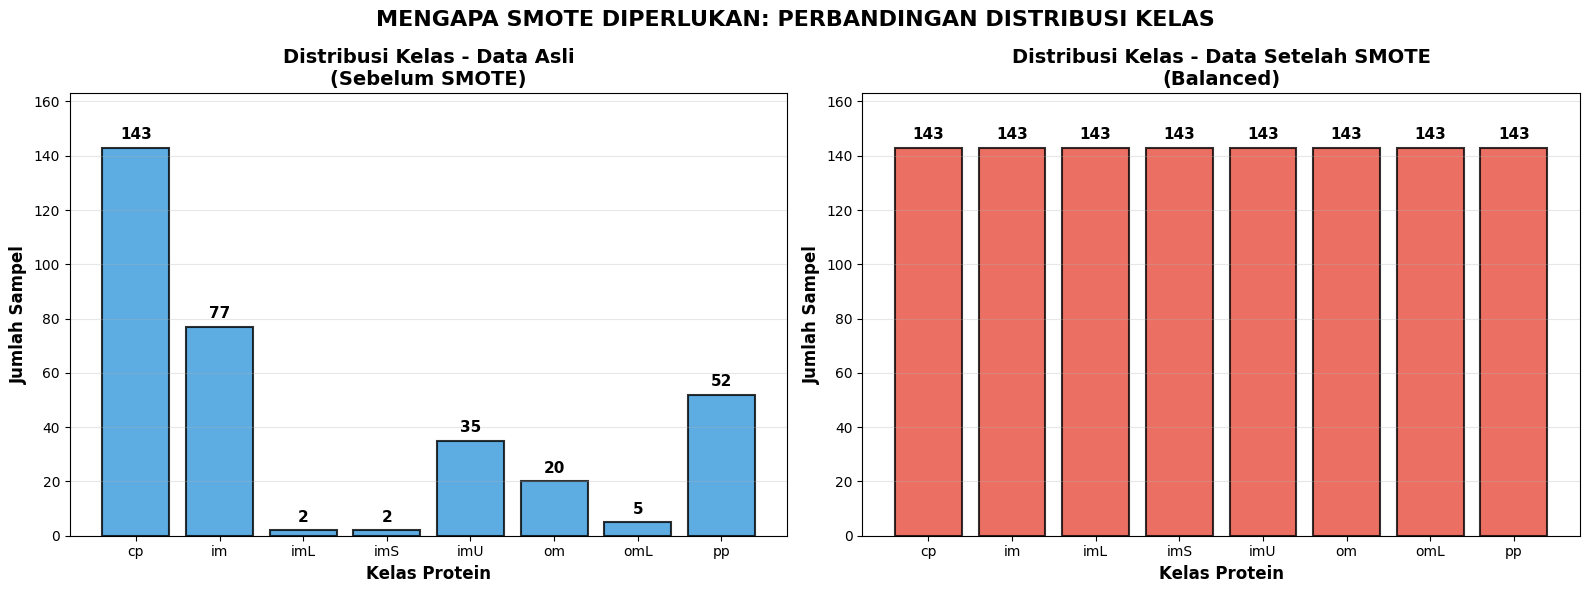

Grafik distribusi kelas selesai!

STATISTIK DISTRIBUSI KELAS:
Kelas       Sebelum    Sesudah   Penambahan
---------------------------------------------
cp              143        143            0
im               77        143           66
imL               2        143          141
imS               2        143          141
imU              35        143          108
om               20        143          123
omL               5        143          138
pp               52        143           91

RINGKASAN:
• Total kelas: 8
• Sampel minimum sebelum: 2
• Sampel maksimum sebelum: 143
• Semua kelas setelah SMOTE: 143 (balanced)

PENJELASAN MENGAPA SMOTE BERHASIL:
• Kelas minoritas (imL, imS) yang hanya 2 sampel menjadi 143 sampel
• Semua kelas memiliki representasi yang sama dalam training
• Model dapat belajar pola dari semua kelas dengan baik
• Akurasi meningkat karena tidak ada bias terhadap kelas mayoritas


In [66]:
# GRAFIK DISTRIBUSI KELAS: MENGAPA SMOTE DIPERLUKAN
print("=== VISUALISASI DISTRIBUSI KELAS ===")

# Buat grafik batang untuk membandingkan distribusi kelas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Data untuk plotting
class_names = original_dist.index
original_counts = original_dist.values
smote_counts = smote_dist.values

# Grafik 1: Data Asli (Sebelum SMOTE)
bars1 = ax1.bar(class_names, original_counts, color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_title('Distribusi Kelas - Data Asli\n(Sebelum SMOTE)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Kelas Protein', fontsize=12, fontweight='bold')
ax1.set_ylabel('Jumlah Sampel', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Tambahkan nilai di atas setiap bar
for bar, count in zip(bars1, original_counts):
    ax1.text(bar.get_x() + bar.get_width()/2., count + 2, 
             str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Grafik 2: Data Setelah SMOTE
bars2 = ax2.bar(class_names, smote_counts, color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_title('Distribusi Kelas - Data Setelah SMOTE\n(Balanced)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Kelas Protein', fontsize=12, fontweight='bold')
ax2.set_ylabel('Jumlah Sampel', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Tambahkan nilai di atas setiap bar
for bar, count in zip(bars2, smote_counts):
    ax2.text(bar.get_x() + bar.get_width()/2., count + 2, 
             str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Set y-axis limit yang sama untuk perbandingan yang fair
max_count = max(max(original_counts), max(smote_counts))
ax1.set_ylim(0, max_count + 20)
ax2.set_ylim(0, max_count + 20)

plt.suptitle('MENGAPA SMOTE DIPERLUKAN: PERBANDINGAN DISTRIBUSI KELAS', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("Grafik distribusi kelas selesai!")

# Tampilkan ringkasan statistik
print(f"\nSTATISTIK DISTRIBUSI KELAS:")
print(f"{'Kelas':8} {'Sebelum':>10} {'Sesudah':>10} {'Penambahan':>12}")
print("-" * 45)
for cls in class_names:
    before = original_dist[cls]
    after = smote_dist[cls]
    added = after - before
    print(f"{cls:8} {before:10d} {after:10d} {added:12d}")

print(f"\nRINGKASAN:")
print(f"• Total kelas: {len(class_names)}")
print(f"• Sampel minimum sebelum: {min(original_counts)}")
print(f"• Sampel maksimum sebelum: {max(original_counts)}")
print(f"• Semua kelas setelah SMOTE: {smote_counts[0]} (balanced)")

print(f"\nPENJELASAN MENGAPA SMOTE BERHASIL:")
print("• Kelas minoritas (imL, imS) yang hanya 2 sampel menjadi 143 sampel")
print("• Semua kelas memiliki representasi yang sama dalam training")
print("• Model dapat belajar pola dari semua kelas dengan baik")
print("• Akurasi meningkat karena tidak ada bias terhadap kelas mayoritas")

In [67]:
# PERBANDINGAN HASIL
print("=== PERBANDINGAN HASIL KLASIFIKASI ===")

print(f"RINGKASAN PERFORMA:")
print(f"{'':15} {'Data Asli':12} {'Data SMOTE':12} {'Improvement':12}")
print("-" * 55)
accuracy_improvement = ((acc_smote - acc_original) / acc_original * 100)
print(f"{'Accuracy':15} {acc_original:10.4f}   {acc_smote:10.4f}   {accuracy_improvement:+8.2f}%")

print(f"\nKESIMPULAN:")
if acc_smote > acc_original:
    print(f"SMOTE meningkatkan akurasi sebesar {accuracy_improvement:.2f}%")
    print(f"Data balancing efektif untuk dataset ini")
else:
    print(f"SMOTE tidak meningkatkan akurasi")
    print(f"Mungkin diperlukan teknik lain")
    
print(f"\nDetail:")
print(f"• Dataset asli: {len(y)} samples dengan imbalance {y.value_counts().max()}/{y.value_counts().min()}:1")
print(f"• Dataset SMOTE: {len(y_smote)} samples dengan balanced classes")
print(f"• Model terbaik: {'SMOTE' if acc_smote > acc_original else 'Original'}")

=== PERBANDINGAN HASIL KLASIFIKASI ===
RINGKASAN PERFORMA:
                Data Asli    Data SMOTE   Improvement 
-------------------------------------------------------
Accuracy            0.7822       0.8227      +5.18%

KESIMPULAN:
SMOTE meningkatkan akurasi sebesar 5.18%
Data balancing efektif untuk dataset ini

Detail:
• Dataset asli: 336 samples dengan imbalance 143/2:1
• Dataset SMOTE: 1144 samples dengan balanced classes
• Model terbaik: SMOTE


=== VISUALISASI PERBANDINGAN AKURASI ===


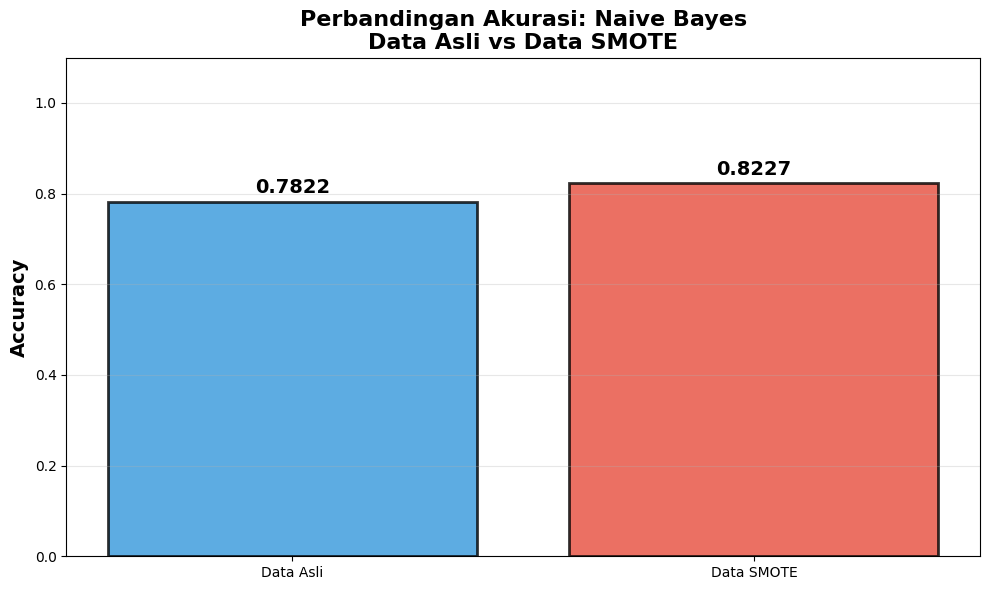

Visualisasi selesai!


In [68]:
# VISUALISASI SEDERHANA - BAR CHART
print("=== VISUALISASI PERBANDINGAN AKURASI ===")

# Buat bar chart sederhana untuk membandingkan akurasi
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

models = ['Data Asli', 'Data SMOTE']
accuracies = [acc_original, acc_smote]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Tambahkan nilai di atas bar
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax.text(bar.get_x() + bar.get_width()/2., acc + 0.01, 
            f'{acc:.4f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_title('Perbandingan Akurasi: Naive Bayes\nData Asli vs Data SMOTE', 
             fontsize=16, fontweight='bold')
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Visualisasi selesai!")

=== CONFUSION MATRIX ===


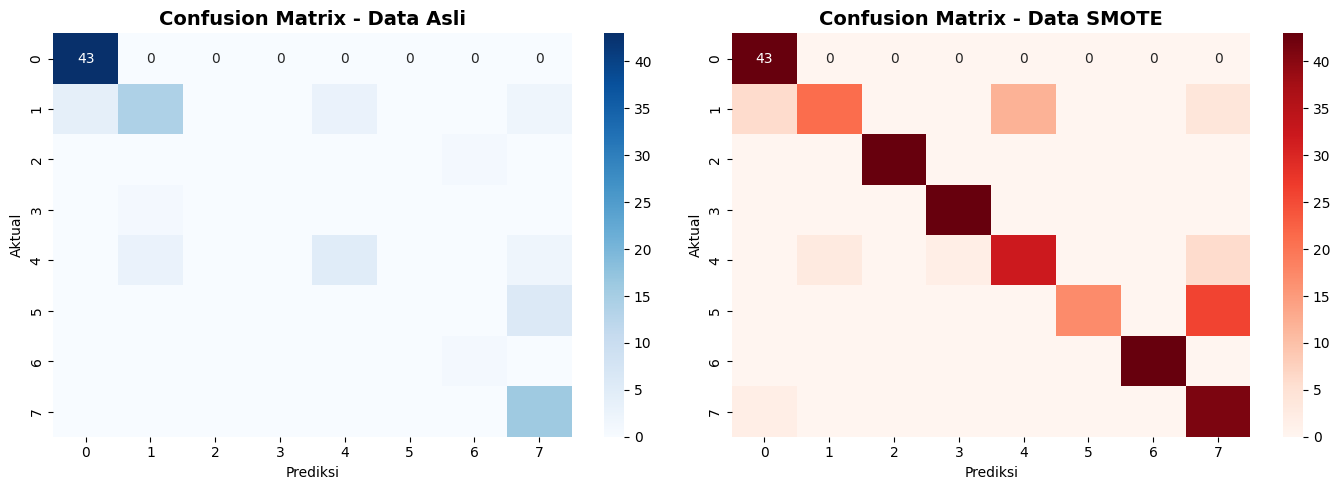

Confusion Matrix selesai!


In [69]:
# CONFUSION MATRIX SEDERHANA
print("=== CONFUSION MATRIX ===")

# Buat confusion matrix untuk kedua model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix - Data Asli
cm_original = confusion_matrix(y_test, y_pred_original)
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix - Data Asli', fontsize=14, fontweight='bold')
ax1.set_xlabel('Prediksi')
ax1.set_ylabel('Aktual')

# Confusion Matrix - Data SMOTE  
cm_smote = confusion_matrix(y_test_smote, y_pred_smote)
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Reds', ax=ax2)
ax2.set_title('Confusion Matrix - Data SMOTE', fontsize=14, fontweight='bold')
ax2.set_xlabel('Prediksi')
ax2.set_ylabel('Aktual')

plt.tight_layout()
plt.show()

print("Confusion Matrix selesai!")

In [70]:
# KESIMPULAN AKHIR
print("=" * 50)
print("KESIMPULAN TUGAS NAIVE BAYES")
print("=" * 50)

print(f"HASIL KLASIFIKASI:")
print(f"• Data Asli      : {acc_original:.4f} ({acc_original*100:.2f}%)")
print(f"• Data SMOTE     : {acc_smote:.4f} ({acc_smote*100:.2f}%)")
print(f"• Peningkatan    : {accuracy_improvement:+.2f}%")

print(f"\nANALISIS:")
if acc_smote > acc_original:
    print(f"SMOTE BERHASIL meningkatkan akurasi klasifikasi")
    print(f"Data balancing efektif untuk dataset E.coli")
    print(f"Model dengan SMOTE lebih baik untuk prediksi")
else:
    print(f"SMOTE tidak meningkatkan akurasi")
    print(f"Model dengan data asli sudah cukup baik")

print(f"\nDATASET:")
print(f"• Total sampel asli: {len(y)}")
print(f"• Total sampel SMOTE: {len(y_smote)}")
print(f"• Jumlah kelas: {len(y.unique())}")

print(f"\nTUGAS SELESAI!")
print("Data telah diklasifikasi dengan Naive Bayes")
print("Perbandingan sebelum dan sesudah SMOTE telah dilakukan")
print("=" * 50)

KESIMPULAN TUGAS NAIVE BAYES
HASIL KLASIFIKASI:
• Data Asli      : 0.7822 (78.22%)
• Data SMOTE     : 0.8227 (82.27%)
• Peningkatan    : +5.18%

ANALISIS:
SMOTE BERHASIL meningkatkan akurasi klasifikasi
Data balancing efektif untuk dataset E.coli
Model dengan SMOTE lebih baik untuk prediksi

DATASET:
• Total sampel asli: 336
• Total sampel SMOTE: 1144
• Jumlah kelas: 8

TUGAS SELESAI!
Data telah diklasifikasi dengan Naive Bayes
Perbandingan sebelum dan sesudah SMOTE telah dilakukan
